In [2]:
import numpy as np
import pandas as pd
import json
import tensorflow as tf
import gensim
import warnings
import keras
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dropout, Input, Embedding, Activation
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from gensim.models import Word2Vec, KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPool1D, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
from gensim.models import KeyedVectors
from nltk.tokenize import sent_tokenize, word_tokenize
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import gensim.downloader as api
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

# New section

In [3]:
# word_vectors = KeyedVectors.load_word2vec_format('PGoogleNews-vectors-negative300.bin', binary=True)
# Load pre-trained word embeddings (word2vec)
word_vectors = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Epoch 1/10, Training Loss: 20.8368, Validation Loss: 6.2626, Training Macro-F1: 0.1524, Validation Macro-F1: 0.2246
Epoch 2/10, Training Loss: 9.5701, Validation Loss: 4.9530, Training Macro-F1: 0.2799, Validation Macro-F1: 0.3226
Epoch 3/10, Training Loss: 7.7842, Validation Loss: 5.2361, Training Macro-F1: 0.3556, Validation Macro-F1: 0.3279
Epoch 4/10, Training Loss: 7.4171, Validation Loss: 4.4813, Training Macro-F1: 0.3776, Validation Macro-F1: 0.3746
Epoch 5/10, Training Loss: 6.5167, Validation Loss: 4.3457, Training Macro-F1: 0.4119, Validation Macro-F1: 0.3765
Epoch 6/10, Training Loss: 5.8143, Validation Loss: 4.3903, Training Macro-F1: 0.4452, Validation Macro-F1: 0.4060
Epoch 7/10, Training Loss: 5.2869, Validation Loss: 4.2665, Training Macro-F1: 0.4755, Validation Macro-F1: 0.4021
Epoch 8/10, Training Loss: 4.8118, Validation Loss: 4.7936, Training Macro-F1: 0.5125, Validation Macro-F1: 0.3789
Epoch 9/10, Training Loss: 4.8685, Validation Loss: 4.4985, Training Macro-F1: 

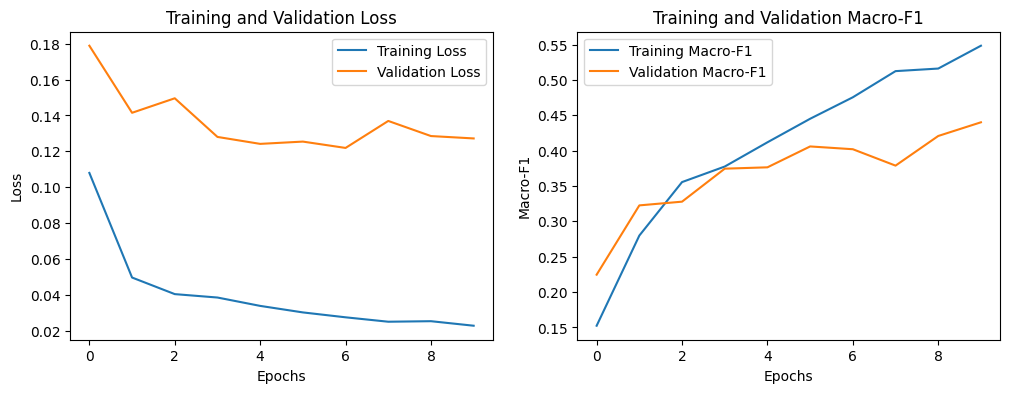

In [11]:
# Define the LSTM-based model
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, word_embeddings):
        super(LSTMTagger, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.linear(lstm_out)
        return tag_space

class ReviewDataset(Dataset):
    def __init__(self, data_path, word_vectors, max_seq_length):
        self.data_path = data_path
        self.word_vectors = word_vectors
        self.max_seq_length = max_seq_length
        self.data = self.load_data()
        self.word_to_idx, self.label_to_idx = self.prepare_vocab()
        self.X, self.y = self.prepare_data()

    def load_data(self):
        with open(self.data_path, 'r') as f:
            data = json.load(f)
        return data

    def prepare_vocab(self):
        word_to_idx = {word: idx + 1 for idx, word in enumerate(self.word_vectors.index_to_key)}
        label_to_idx = {"O": 1, "B_RESPONDENT": 2, "I_RESPONDENT": 3, "B_DATE": 4, "I_DATE":5, "B_GPE": 6, "I_GPE": 7, "B_PROVISION": 8,
                "I_PROVISION": 9, "B_STATUTE": 10, "I_STATUTE": 11, "B_ORG": 12, "B_CASE_NUMBER": 13, "I_CASE_NUMBER": 14,
                "B_OTHER_PERSON": 15, "I_OTHER_PERSON": 16, "B_WITNESS": 17, "I_WITNESS": 18, "I_ORG": 19, "B_JUDGE": 20, "I_JUDGE": 21,
                "B_PETITIONER": 22, "I_PETITIONER": 23, "B_COURT": 24, "I_COURT": 25, "B_PRECEDENT": 26, "I_PRECEDENT": 0}
        return word_to_idx, label_to_idx

    def prepare_data(self):
        X, y = [], []
        for sample in self.data.values():
            text = sample['text'].split(' ')
            labels = sample['labels']
            text_indices = [self.word_to_idx.get(word, 0) for word in text]
            X.append(torch.tensor(text_indices))
            y.append(torch.tensor([self.label_to_idx[label] for label in labels]))
        X_padded = pad_sequence(X, batch_first=True, padding_value=0)
        y_padded = pad_sequence(y, batch_first=True, padding_value=0)
        return X_padded, y_padded

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_f1s = []
    val_f1s = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        train_all_preds = []
        train_all_labels = []
        for text, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(text)
            loss = criterion(outputs.view(-1, tagset_size), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 2)
            train_all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
            train_all_labels.extend(labels.view(-1).cpu().numpy().tolist())

        val_loss = 0
        val_all_preds = []
        val_all_labels = []
        with torch.no_grad():
            model.eval()
            for text, labels in val_loader:
                outputs = model(text)
                loss = criterion(outputs.view(-1, tagset_size), labels.view(-1))
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 2)
                val_all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
                val_all_labels.extend(labels.view(-1).cpu().numpy().tolist())

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_f1 = f1_score(train_all_labels, train_all_preds, average='macro')
        val_f1 = f1_score(val_all_labels, val_all_preds, average='macro')
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Macro-F1: {train_f1:.4f}, Validation Macro-F1: {val_f1:.4f}")

    return train_losses, val_losses, train_f1s, val_f1s

max_seq_length = 100

# Create data loaders
train_dataset = ReviewDataset('NER_train.json', word_vectors, max_seq_length)
val_dataset = ReviewDataset('NER_val.json', word_vectors, max_seq_length)
test_dataset = ReviewDataset('NER_test.json', word_vectors, max_seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define model parameters
embedding_dim = word_vectors.vector_size
hidden_dim = 128
vocab_size = len(word_vectors.index_to_key)
tagset_size = 28

# Train the model
model = LSTMTagger(embedding_dim, hidden_dim, vocab_size, tagset_size, torch.FloatTensor(word_vectors.vectors))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0175)

train_losses, val_losses, train_f1s, val_f1s = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Generate plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_f1s, label='Training Macro-F1')
plt.plot(val_f1s, label='Validation Macro-F1')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1')
plt.legend()
plt.title('Training and Validation Macro-F1')
plt.show()

# Save the model for future inference
torch.save(model.state_dict(), 't1_model2_word2vec.pt')

# for 0.015 Epoch 10/10, Training Loss: 4.5007, Validation Loss: 4.4191, Training Macro-F1: 0.5605, Validation Macro-F1: 0.4281
